# Review tweets in database
pull tweets out of a database by their timing information. Example dataset: #Sowoozoo during replay of D1

To use this notebook, make sure you have python installed (I recommend using anaconda to get set up quickly), then download this repo (or at least the notebook and twt.py file), and a folder named sowoozoo_data shared by gdrive, and make sure they are all in the folder on your computer (files Check_Twts... twt.py and folder /sowoozoo_data/)

Note: the Fan_tweets_H_Sowoozoo_R1.csv file containes all tweets with the hashtag #sowoozoo as caught in the 3.5 hours around the live streamed concert EXCLUDING tweets and retweets of tweets by official accounts @BTS_TWT and @bighit_bts. The results is a database of tweets primarily by fans who are concurrently watching the performance live stream. A cell below clears out the weverse and hybe merch tweets as well. 

This notebook is a code script that you can run one cell at a time, starting from the top. You can also copy paste and edit these cells to change their outputs to whatever you need.

To run a cell, selected it with your mouse or keyboard (gets outlined in a green box) and click run or press shift-return (run cell and move to next) or command/ctrl-return (run cell and keep it selected). 

Some cells, like this one, are just markdown (see drop down menu after the fast forward button) others are code. Markdown cells might look different if you click on them, as you enter edit mode, but all you can change is the text they contain. Code cells actually execute commands when they run, which means sometimes they break or give funny outputs. Code cells also contain comments (line starts with #) which are bits of text that are ignored when the cell is run. These commented out lines may be explanations or alternative codes to run for different outputs. 

The code cells below should work if you don't change them (and the right libraries are installed, and the files are in the right place).


In [2]:
# the first code cell imports all the python libraries needed for this code to work. 
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
# besides the published libraries used by this code, 
# I have a set of special twitter database functions that hang out in the twt.py file you downloaded.

# This cell imports just functions from twt.py file
%reload_ext autoreload
%autoreload 1
%aimport twt

Now that the code libraries are lined up and primed, we can pull in the database of tweets to explore and the database of concurrent events. The notebook uses the tweets from around the replay of the first sowoozoo concert.

In [25]:
# retrieve the fan tweets from during the concert R1 and the timing information for the events
# go into the data folder
os.chdir('./sowoozoo_data/') 

# set a name for this database of tweets to be used when generating plots and outputing files
data_name = 'SWZ_R1' # change R1 to R2, or D2, or D1 to see the other concerts data

# convert the csv file into a pandas database to be manipulated within this notebook
df_alltwt=pd.read_csv('Fan_tweets_H_Sowoozoo' + data_name[-3:] + '.csv')
# make sure the time values are machine readable
df_alltwt["created_at"] = pd.to_datetime(df_alltwt["created_at"]) 

# load the timing of concert events
concert_times=pd.read_csv('Setlists_sowoozoo' + data_name[-3:] + '.csv') 
# NOTE: concert times aligned so songs begin less than a minute before the first yell tweet of recognition in live music segments
# convert times to datetime data type and set as index
concert_times["starttime"] = pd.to_datetime(concert_times["starttime"])
concert_times=concert_times.set_index("starttime", drop=True)
os.chdir('..') # return to the main folder

In [26]:
# jupyter outputs informatino that we specifically print() or plots that are shown
# but you can also get a quick peak at a variable by leaving it as the last row of code in a cell
# so here, we can see the concert time tale with just the below:
concert_times

# Note: all concert times are in UTC time

,order,event
starttime,,
2021-06-19 01:00:30+00:00,0,Pre-stream
2021-06-19 01:05:30+00:00,1,tinytans open
2021-06-19 01:06:55+00:00,2,VCR1 - wake up
2021-06-19 01:09:42+00:00,3,Life goes on
2021-06-19 01:13:00+00:00,4,Butter
2021-06-19 01:15:49+00:00,5,Dynamite--Tropical
2021-06-19 01:19:05+00:00,6,Live 1
2021-06-19 01:26:25+00:00,7,ARMY signals
2021-06-19 01:34:22+00:00,8,Moving On


In [27]:
# and here is an example of what a single tweet look like
df_alltwt.iloc[0,:]

id                                                                     1406046579362959361
created_at                                                       2021-06-19 00:30:02+00:00
tweet                                    RT @_candyclover: ติดตาม ‘BTS 2021 MUSTER #SOW...
source                                                                 Twitter for Android
language                                                                                th
user_id                                                                          105739459
user_screen_name                                                            GlangJinnieJin
user_name                                                                      ⟭⟬𝗝𝗜𝗡🐹진💜⟬⟭⁷
user_description                         I'M THE ONE I SHOULD LOVE IN THIS WORLD ♡ JIN'...
user_language                                                                          NaN
user_location                                                                 🐨🐹🐱🐿🐥🐻🐰 💜OT7

In [28]:
# and here is a truncated view of a few in the pandas database
df_alltwt.iloc[0:5,:]

,id,created_at,tweet,source,language,user_id,user_screen_name,user_name,user_description,user_language,...,quoted_status_user_id,quoted_status_user_screen_name,quoted_status_user_name,quoted_status_user_description,quoted_status_user_friends_count,quoted_status_user_statuses_count,quoted_status_user_followers_count,quoted_status_retweet_count,quoted_status_favorite_count,quoted_status_reply_count
0,1406046579362959361,2021-06-19 00:30:02+00:00,RT @_candyclover: ติดตาม ‘BTS 2021 MUSTER #SOW...,Twitter for Android,th,105739459,GlangJinnieJin,⟭⟬𝗝𝗜𝗡🐹진💜⟬⟭⁷,I'M THE ONE I SHOULD LOVE IN THIS WORLD ♡ JIN'...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1406046586287771651,2021-06-19 00:30:03+00:00,RT @weverseofficial: 잠시 후 오전 10시(KST)부터 BTS 20...,Twitter for Android,ko,1389913555034460160,luvlyhueningkai,ally ❅,- for @BTS_twt & @TXT_members (she/her) OT7 & OT5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1406046587361562628,2021-06-19 00:30:04+00:00,RT @lomlbngtan: Taehyung HD pics from muster d...,Twitter for Android,en,1337216502043447299,_Taeani_,ᥫ᭡𓂃 : 𝗮𝗇𝗂 ֢ 💭 🔗 ꒱,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1406046590691803142,2021-06-19 00:30:04+00:00,RT @weverseofficial: まもなく午前10時よりBTS 2021 MUSTE...,Twitter for iPhone,ja,1033851282220445696,s_umejan,alex@still under a state of emergency,I’m alex.Unfriendly. I like BTS(2018/6) J-HOPE...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1406046593762041859,2021-06-19 00:30:05+00:00,RT @weverseofficial: BTS 2021 MUSTER SOWOOZOO ...,Twitter for Android,en,1317482645127712771,jmxnzbee,bobabear🧸,#BTS \n#방탄소년단 \n#BTSARMY \n#SmoothLikeButter ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# now we start processing the tweets database. 
# first we make sure all official tweet retweets are removed.
print('Size of full set: ' + str(len(df_alltwt)))

# we filter out the tweets that are Retweets and Quote Tweets of the official accounts.
# this information is excluded by reading the tweet content are excluding any that include the bits of string below in red
twts = df_alltwt['tweet'] 
df_fantwt = df_alltwt.loc[~(twts.str.contains('T @weverseofficial:', case=False,regex=False)
                            |twts.str.contains('T @HYBE_MERCH:', case=False,regex=False)
                            |twts.str.contains('T @bts_bighit:', case=False,regex=False)
                            |twts.str.contains('T @BTS_twt:', case=False,regex=False))] # 
# this filtering out of tweets removed about a quarter of database!
print('Size of cleaned set: ' + str(len(df_fantwt)))
df_alltwt = df_fantwt.copy()
# note: if you run this cell a second time, the numbers will match, 
# as we are updating the original variable.

Size of full set: 18706
Size of cleaned set: 13163


In [30]:
# check the time range of database imported (UTC 0)
time_start = df_alltwt['created_at'].min()
time_end = df_alltwt['created_at'].max()
print([time_start,time_end])

# reorder tweets to be in chronological order (convenient for computation to follow)
df_alltwt_ord = df_alltwt.sort_values('created_at')
df_alltwt_ord = df_alltwt_ord.reset_index(drop=True)

[Timestamp('2021-06-19 00:30:02+0000', tz='UTC'), Timestamp('2021-06-19 03:59:57+0000', tz='UTC')]


Now generate a plot of the number of tweets per minute, to give an overview of the twitter activity captured in this database

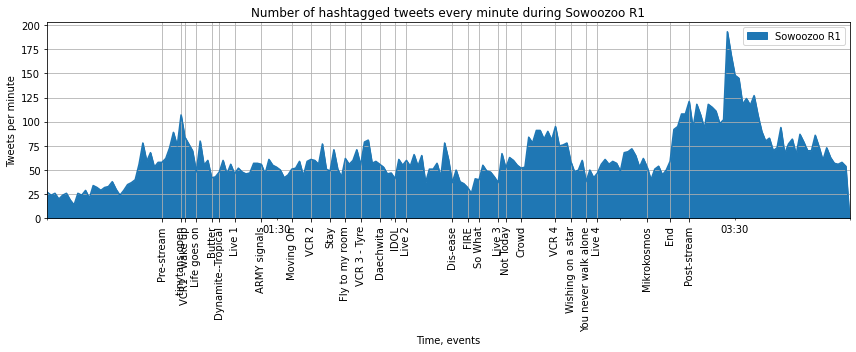

In [31]:
# plot the nubmer of tweets posted a minute!

# concert started airing at 9:30 UTC (18:30 KST, UTC +9) ['2021-06-13 9:30:00+0000','2021-06-13 11:45:00+0000'] 
minutely_dt = pd.date_range(pd.to_datetime('2021-06-19 00:30:00+0000'), pd.to_datetime('2021-06-19 04:00:00+0000'), freq='1Min')
df_mn_counts = pd.DataFrame(index = minutely_dt)
df_counted = twt.ind_set_counts(df_alltwt_ord,'created_at',minutely_dt)
df_mn_counts['Sowoozoo R1'] = df_counted['Counts'].values

df_mn_counts.plot.area(figsize=(12,5))
plt.title('Number of hashtagged tweets every minute during Sowoozoo ' + data_name[-2:])
plt.xlabel('Time, events')
plt.ylabel('Tweets per minute')

plt.xticks(concert_times.index,concert_times.event, rotation='vertical')
plt.grid()
plt.tight_layout()
# the code in line 19 is commented out to avoid generating a plot file, but if you want output
# the graph, remove the hashtag and run the cell 
#plt.savefig('ALL_Fans_Tweet_rate_'+ data_name + '.png',dpi = 300)
plt.show()

Now seperate out different categories of tweets and report some descriptive statistics. This produces a four more tweet databases that you can explore individually, instead of looking all the tweets mixed into one as collected. 

If you want to look at retweets specifically for any of the cells below, change the database variable name in the code to df_RT, for original tweets use df_Ori, for replys df_replys, for quote twets df_QT


In [32]:
set_size = len(df_alltwt_ord)
print('Full set: ' + str(set_size) + ' tweets by ' +  str(len(df_alltwt_ord['user_id'].unique())) + ' users' )

# original tweets, replys, amplification tweets
df_replys = df_alltwt_ord.loc[df_alltwt_ord['in_reply_to_user_id'].notna(),:].reset_index()
print('Number of reply tweets in set: ' + str(len(df_replys))  + ' (' + str(len(df_replys)/set_size) + ')')
print('    Replying to ' + str(len(df_replys['in_reply_to_user_id'].unique())) + ' tweets')

df_RT = df_alltwt_ord.loc[df_alltwt_ord['retweeted_status_id'].notna(),:].reset_index()
print('Number of retweeting tweets in set: ' + str(len(df_RT))  + ' (' + str(len(df_RT)/set_size) + ')')
print('    Retweeting ' + str(len(df_RT['retweeted_status_id'].unique())) + ' tweets')

df_QT = df_alltwt_ord.loc[df_alltwt_ord['quoted_status_id'].notna(),:].reset_index()
print('Number of quote tweeting tweets in set: ' + str(len(df_QT)) + ' (' + str(len(df_QT)/set_size) + ')')
print('    Quoting ' + str(len(df_QT["quoted_status_id"].unique())) + ' tweets')

df_Ori = df_alltwt_ord.loc[df_alltwt_ord['retweeted_status_id'].isna(),:]
df_Ori = df_Ori.loc[df_Ori['quoted_status_id'].isna(),:] 
df_Ori = df_Ori.loc[df_Ori['in_reply_to_status_id'].isna(),:].reset_index()                    
print('Number of Original tweets in set: ' + str(len(df_Ori)) + ' (' + str(len(df_Ori)/set_size) + ')')
print('    with ' + str(len(df_Ori["tweet"].unique())) + ' unique messages by ' +  str(len(df_Ori["user_id"].unique())) + ' users')


Full set: 13163 tweets by 7251 users
Number of reply tweets in set: 146 (0.011091696421788345)
    Replying to 75 tweets
Number of retweeting tweets in set: 9580 (0.7277976145255641)
    Retweeting 1075 tweets
Number of quote tweeting tweets in set: 563 (0.04277140469497835)
    Quoting 166 tweets
Number of Original tweets in set: 3249 (0.24682823064650916)
    with 3239 unique messages by 1914 users


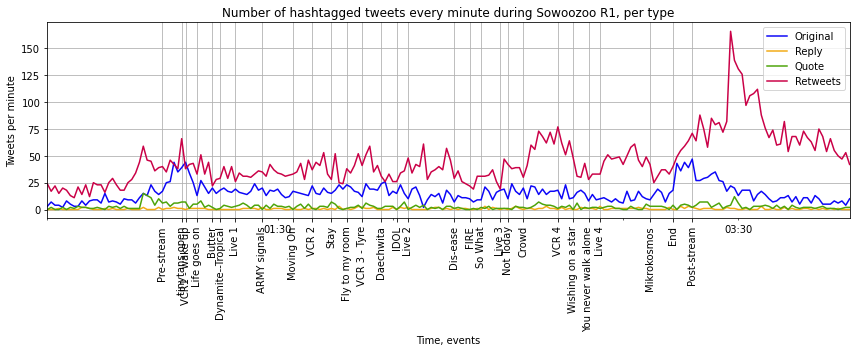

In [33]:
# capture the minute wise rate of each tweet category 
df_mn_counts = pd.DataFrame(index = minutely_dt)
df_counted = twt.ind_set_counts(df_Ori,'created_at',minutely_dt)
df_mn_counts['Original'] = df_counted['Counts'].values
df_counted = twt.ind_set_counts(df_replys,'created_at',minutely_dt)
df_mn_counts['Reply'] = df_counted['Counts'].values
df_counted = twt.ind_set_counts(df_QT,'created_at',minutely_dt)
df_mn_counts['Quote'] = df_counted['Counts'].values
df_counted = twt.ind_set_counts(df_RT,'created_at',minutely_dt)
df_mn_counts['Retweets'] = df_counted['Counts'].values

df_mn_counts=df_mn_counts.drop(index=[df_mn_counts.iloc[-1].name])

cmap1 = ListedColormap(["xkcd:strong blue", "xkcd:squash", "xkcd:lawn green", "xkcd:ruby"])

df_mn_counts.plot.line(figsize=(12,5),cmap=cmap1)
plt.title('Number of hashtagged tweets every minute during Sowoozoo ' + data_name[-2:] + ', per type')
plt.xlabel('Time, events')
plt.ylabel('Tweets per minute')

plt.xticks(concert_times.index,concert_times.event, rotation='vertical')#, concert_times['event'])
plt.grid()
plt.tight_layout()
#plt.savefig('ALL_Fans_Tweet_Types_rate_'+ data_name + '.png',dpi = 300)
plt.show()

## Sampling tweets
The section that follows pulls tweets from the database in a few configurations. 

In [34]:
# get all the details for single tweet in a databse by index or row number
#print(df_RT.iloc[0,:]) # specify by row number (not index) with iloc
print(df_RT.loc[7578,:]) # specify by index number (first number printed in twt_dets) with loc

index                                                                                10841
id                                                                     1406092243098750983
created_at                                                       2021-06-19 03:31:29+00:00
tweet                                    RT @Jungkook1997230: แจกรอบรีรันพน.2คนสำหรับคน...
source                                                                 Twitter for Android
language                                                                                th
user_id                                                                1177960548148711424
user_screen_name                                                                Purple_52x
user_name                                                                ∞ 𝐏𝐮𝐫◕𝐩𝐥𝐞 𝐜𝐨𝐥𝐨𝐫 ∞
user_description                                  ◕pleasure to meet you 💜\n#โบ๊ะบ๊ะแฟมิลี่
user_language                                                                          NaN

In [35]:
# specify a range of time by hand (follow data formating carefully like '2021-06-19 02:20:17+00:00')
# and print the first 10 retweets in the interval
# with the more verbose printing function twt.twt_dets

start_t = '2021-06-19 02:20:17+00:00'
end_t = '2021-06-19 02:21:17+00:00'
Max_Tweets = 5 # set a maximum number of tweets to look at, make huge if you don't want to limit the output
a = twt.ind_set(df_RT,'created_at',start_t,end_t)

print('start time: ' + start_t)
print('end time: ' + end_t)
print('Number of retweet tweets in this interval: ' + str(len(a)) + '\n')
print('first '+ str(min([len(a),Max_Tweets]))+' retweets:')
#print each tweet in interval of time for event listed
for i, row in a[:min([len(a),Max_Tweets])].iterrows():
    print(str(i) + ', ' + str(row['created_at']) +': ')
    print(twt.twt_dets(row)+'\n')

start time: 2021-06-19 02:20:17+00:00
end time: 2021-06-19 02:21:17+00:00
Number of retweet tweets in this interval: 21

first 5 retweets:
3756, 2021-06-19 02:20:19+00:00: 
ly._xmoarmyen-「💜」𝕓𝕠𝕣𝕒𝕙𝕒𝕖 。 [@ly_xsomeday],2021-06-19 02:20:19+00:00:
https://twitter.com/anyuser/status/1406074333315801094
RT @AnongnapatW: สภาพคนดูรีรันเช้านี้ อย่าหาจัดอะไรเช้าๆอีกนะ บฮ. มี่ขอละ 😂 #SOWOOZOO https://t.co/Z87SRdjUb3
RTs: 284
Likes: 237


3757, 2021-06-19 02:20:26+00:00: 
ᯓ 𝒥𝒶𝓉𝒾𝓁𝒶˚ ༘ ꕤ 🥞✨ [@xxdreamyj],2021-06-19 02:20:26+00:00:
https://twitter.com/anyuser/status/1406074361962897411
RT @AnongnapatW: สภาพคนดูรีรันเช้านี้ อย่าหาจัดอะไรเช้าๆอีกนะ บฮ. มี่ขอละ 😂 #SOWOOZOO https://t.co/Z87SRdjUb3
RTs: 286
Likes: 240


3758, 2021-06-19 02:20:27+00:00: 
Army~~🟪Kookv🐰🐯 [@ArmyKoo01804173],2021-06-19 02:20:27+00:00:
https://twitter.com/anyuser/status/1406074367415504896
RT @Pniiam_: #SOWOOZOO การ์ดแข็งที่ระลึก 💌💕
🌟 ลงฟอร์มวันอาทิตย์ที่ 20 เวลา 20.00 น.
🌟 ค่าส่งจะอยู่ในฟอร์มนะคะ เดี๋ยวมีการโอนกันมาก่อน555
🌟 ไม่ต

In [36]:
# Show all the Original tweets posted during the performance of FIRE
# using the time stamps listed in the concert_times database
# tweets are printed in APA format using the twt.citation function.

event_n = 17
a = twt.ind_set(df_Ori,'created_at',concert_times.index[event_n],concert_times.index[event_n+1])

print(concert_times.iloc[event_n,:])
print(concert_times.index[event_n+1].tz_localize(None)-concert_times.index[event_n].tz_localize(None))
print('Number of tweets in this interval: ' + str(len(a)) + '\n')

#print each tweet in interval of time for event listed. Here I didn't limit the output because it's more compact
for i, row in a.iterrows():
    print(str(i) + ', ' + str(row['created_at']) +': ')
    print(twt.citation(row)+'\n')
#a.iloc[:10,:]

order      17
event    FIRE
Name: 2021-06-19 02:20:17+00:00, dtype: object
0 days 00:03:21
Number of tweets in this interval: 29

1706, 2021-06-19 02:20:17+00:00: 
みぴょん [@mipyon_suga]. (2021, 06 19). シングルビューでも1度目と2度目で気付くところが全然違うから、マルチビューやったらもっとたくさんのことに気付くんだろうなぁ(*´꒳`*) ぜひマルチビューバージョンでDVD化して欲しい☺️📀  #SOWOOZOO[Tweet]. Twitter. https://twitter.com/anyuser/status/1406074325875126277

1707, 2021-06-19 02:20:18+00:00: 
•TRD• [@TRDJDK1]. (2021, 06 19). พี่จิน💜🤏🏻 #SOWOOZOO https://t.co/baaOmV5XBO[Tweet]. Twitter. https://twitter.com/anyuser/status/1406074329415053317

1708, 2021-06-19 02:20:19+00:00: 
- Aisys⁷ 🧈 ★ 0613-0709 [@icedxlattae]. (2021, 06 19). SICK AND TIIIIIRED 🗣 #SOWOOZOO https://t.co/d8TkSIkwur[Tweet]. Twitter. https://twitter.com/anyuser/status/1406074335585001474

1709, 2021-06-19 02:20:21+00:00: 
Amy⁷∞🧈 [@dastardlypale]. (2021, 06 19). Dis-ease is too good 🙌 #SOWOOZOO[Tweet]. Twitter. https://twitter.com/anyuser/status/1406074343793246212

1710, 2021-06-19 02:20:31+00:00: 
＊あみ＊ [

The urls generated here are all of the form .../anyuser/status... and while that doesn't look like a normal twitter url, it will successfully redirect to the original tweet IF it still exists. 

Anyway, change which concert database you are drawing from, which times to look at, which events to consider over and you should be able to explore the collected tweets with a touch more conveninence than the raw csv databases. LMK if you hit any snags!